"""
Tutorial 02: Context Decoding
=========================================

In this tutorial you will learn about the context decoding tools included with
BrainStat. The context decoding module consists of three parts: genetic
decoding, meta-analytic decoding and histological comparisons. Before we start,
lets run a linear model testing for the effects of age on cortical thickness as
we did in Tutorial 1. We'll use the results of this model later in this
tutorial.
"""

In [1]:
from brainstat.datasets import fetch_mask, fetch_template_surface
from brainstat.stats.SLM import SLM
from brainstat.stats.terms import FixedEffect, MixedEffect
from brainstat.tutorial.utils import fetch_mics_data

thickness, demographics = fetch_mics_data()
mask = fetch_mask("fsaverage5")

term_age = FixedEffect(demographics.AGE_AT_SCAN)
term_sex = FixedEffect(demographics.SEX)
term_subject = MixedEffect(demographics.SUB_ID)
model = term_age + term_sex + term_age * term_sex + term_subject

contrast_age = -model.mean.AGE_AT_SCAN
slm = SLM(
    model,
    contrast_age,
    surf="fsaverage5",
    mask=mask,
    correction=["fdr", "rft"],
    two_tailed=False,
    cluster_threshold=0.01,
)
slm.fit(thickness)


/usr/local/lib/python3.9/site-packages/requests/__init__.py:109: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (5.0.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn(


###################################################################
# Genetics
# --------
#
# For genetic decoding we use the Allen Human Brain Atlas through the abagen
# toolbox. Note that abagen only accepts parcellated data. Here is a minimal
# example of how we use abagen to get the genetic expression of the 100 regions
# of the Schaefer atlas and how to plot this expression to a matrix. Please note
# that downloading the dataset and running this analysis can take several
# minutes.

2022-09-21 14:54:15,785 - brainstat - INFO - If you use BrainStat's genetics functionality, please cite abagen (https://abagen.readthedocs.io/en/stable/citing.html).


/usr/local/lib/python3.9/site-packages/abagen/samples_.py:404: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gene_by_label = (microarray.groupby('label')
/usr/local/lib/python3.9/site-packages/abagen/samples_.py:404: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gene_by_label = (microarray.groupby('label')
/usr/local/lib/python3.9/site-packages/abagen/samples_.py:404: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gene_by_label = (microarray.groupby('label')
/usr/local/lib/python3.9/site-packages/abagen/samples_.py:404: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gene_by_label = (microarray.groupby('label')
/usr/local/lib/python3.9/sit

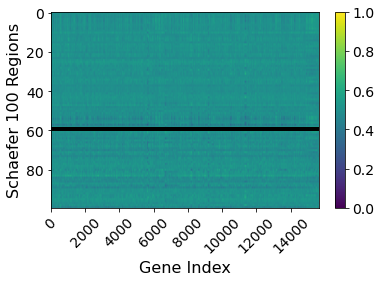

In [2]:
import copy

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from brainspace.utils.parcellation import reduce_by_labels
from matplotlib.cm import get_cmap

from brainstat.context.genetics import surface_genetic_expression
from brainstat.datasets import fetch_parcellation

# Get Schaefer-100 genetic expression.
schaefer_100_fs5 = fetch_parcellation("fsaverage5", "schaefer", 100)
surfaces = fetch_template_surface("fsaverage5", join=False)
expression = surface_genetic_expression(schaefer_100_fs5, surfaces, space="fsaverage")

# Plot Schaefer-100 genetic expression matrix.
colormap = copy.copy(get_cmap())
colormap.set_bad(color="black")
plt.imshow(expression, aspect="auto", cmap=colormap)
plt.colorbar().ax.tick_params(labelsize=14)
plt.xticks(fontsize=14, rotation=45)
plt.yticks(fontsize=14)
plt.xlabel("Gene Index", fontdict={"fontsize": 16})
plt.ylabel("Schaefer 100 Regions", fontdict={"fontsize": 16})
plt.gcf().subplots_adjust(bottom=0.2)

In [ ]:
########################################################################
# Expression is a pandas DataFrame which shows the genetic expression of genes
# within each region of the atlas. By default, the values will fall in the range
# [0, 1] where higher values represent higher expression. However, if you change
# the normalization function then this may change. Some regions may return NaN
# values for all genes. This occurs when there are no samples within this
# region across all donors. We've denoted this region with the black color in the
# matrix. By default, BrainStat uses all the default abagen parameters. If you wish to
# customize these parameters then the keyword arguments can be passed directly
# to `surface_genetic_expression`. For a full list of these arguments and their
# function please consult the abagen documentation.
#
# Next, lets have a look at the correlation between one gene (WFDC1) and our
# t-statistic map. Lets also plot the expression of this gene to the surface.

# Plot correlation with WFDC1 gene
t_stat_schaefer_100 = reduce_by_labels(slm.t.flatten(), schaefer_100_fs5)[1:]

df = pd.DataFrame({"x": t_stat_schaefer_100, "y": expression["WFDC1"]})
df.dropna(inplace=True)
plt.scatter(df.x, df.y, s=20, c="k")
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("t-statistic", fontdict={"fontsize": 16})
plt.ylabel("WFDC1 expression", fontdict={"fontsize": 16})
plt.plot(np.unique(df.x), np.poly1d(np.polyfit(df.x, df.y, 1))(np.unique(df.x)), "k")
plt.text(-1.0, 0.75, f"r={df.x.corr(df.y):.2f}", fontdict={"size": 14})
plt.show()

/usr/local/lib/python3.9/site-packages/brainspace/plotting/base.py:287: UserWarning: Interactive mode requires 'panel'. Setting 'interactive=False'
  warnings.warn("Interactive mode requires 'panel'. "


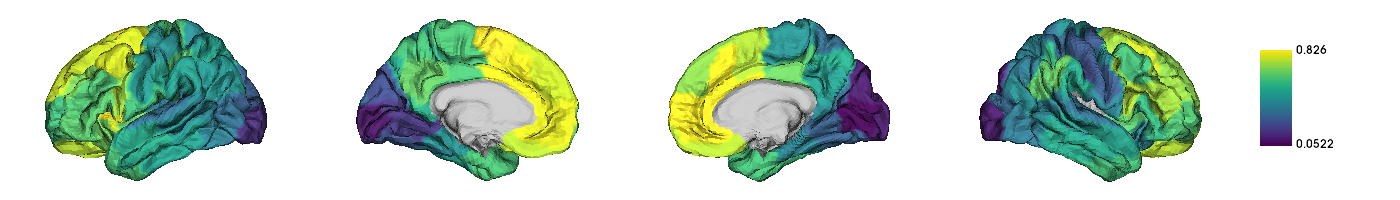

In [3]:
########################################################################

# Plot WFDC1 gene to the surface.
from brainspace.plotting.surface_plotting import plot_hemispheres
from brainspace.utils.parcellation import map_to_labels

vertexwise_WFDC1 = map_to_labels(
    expression["WFDC1"].to_numpy(),
    schaefer_100_fs5,
    mask=schaefer_100_fs5 != 0,
    fill=np.nan,
)

plot_hemispheres(
    surfaces[0],
    surfaces[1],
    vertexwise_WFDC1,
    color_bar=True,
    embed_nb=True,
    size=(1400, 200),
    zoom=1.45,
    nan_color=(0.7, 0.7, 0.7, 1),
    cb__labelTextProperty={"fontSize": 12},
)

In [4]:

########################################################################
# We find a small correlation. To test for significance we'll have
# to do some additional corrections, but more on that later.
#
# Meta-Analytic
# -------------
# To perform meta-analytic decoding, BrainStat uses precomputed Neurosynth maps.
# Here we test which terms are most associated with a map of cortical thickness.
# A simple example analysis can be run as follows. The surface decoder
# interpolates the data from the surface to the voxels in the volume that are in
# between the two input surfaces. We'll decode the t-statistics derived with our model
# earlier. Note that downloading the dataset and running this analysis can take several minutes.

from brainstat.context.meta_analysis import meta_analytic_decoder

meta_analysis = meta_analytic_decoder("fsaverage5", slm.t.flatten())
print(meta_analysis)

2022-09-21 14:58:29,126 - brainstat - INFO - Fetching Neurosynth feature files. This may take several minutes if you haven't downloaded them yet.
2022-09-21 14:58:29,447 - brainstat - INFO - Running correlations with all Neurosynth features.
                    Pearson's r
nucleus accumbens      0.207419
accumbens              0.207216
dorsal anterior        0.200371
dacc                   0.196472
ventral striatum       0.194027
...                         ...
selectivity           -0.225783
object recognition    -0.231140
v1                    -0.232876
lateral occipital     -0.233367
sighted               -0.250493

[3228 rows x 1 columns]
